In [1]:
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import keras
import datetime

from random import randint
from numpy import array
from numpy import argmax
from random import randint
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense


from math import sin
from math import pi
from math import exp
from random import randint
from random import uniform

from numpy import array
from math import ceil
from math import log10
from keras.layers import TimeDistributed
from keras.layers import RepeatVector

from random import random
from numpy import cumsum
from numpy import array_equal
from keras.layers import Bidirectional

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import pickle

from sklearn.preprocessing import MinMaxScaler

import re

import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

tf.keras.backend.set_session(session)

# Eval transformation functions

def most_common(lst): 
    return max(set(lst), key = lst.count)

def reveal_bias(url):
    path = url.split('/', 1)[1]
    apps = re.sub('[/-]', ' ',path).split()[:-1]
    return most_common(apps)

def add_bias_labels(col_lst):
    for i in range(len(col_lst)):
        col_lst[i] = col_lst[i] + "-bias-" + reveal_bias(col_lst[i])
    return col_lst

def create_reqset_dict(col_list, req_list):
    reqset_dict = dict(zip(add_bias_labels(col_list),req_list))
    return reqset_dict

def get_reqset_bias(dictionary):
    bias_2 = sum([v for k,v in dictionary.items() if "-bias-2" in k])
    bias_3 = sum([v for k,v in dictionary.items() if "-bias-3" in k])
    bias_4 = sum([v for k,v in dictionary.items() if "-bias-4" in k])
    
    return (bias_2, bias_3, bias_4)

def get_app_bias_error(X_test, y_test, model):
    error_vectors_app_bias = list()
    for i in range(len(X_test)):
        predict_dict = create_reqset_dict([col for col in test_df.columns if "CS_" in col], model.predict(X_test[i].reshape(1,1000,129))[0])
        predict_bias = get_reqset_bias(predict_dict)

        actual_dict = create_reqset_dict([col for col in test_df.columns if "CS_" in col], y[i])
        actual_bias = get_reqset_bias(actual_dict)

        error_vectors_app_bias.append(np.absolute(np.array(actual_bias) - np.array(predict_bias)))

    return error_vectors_app_bias

train_df = pd.read_parquet('train.parquet')
test_df = pd.read_parquet('test.parquet')

# First half of Test as validation - second half: holdout

holdout_df = test_df[:1120000]
test_df = test_df[1120000:2240000]

# Prepare test data as validation

y_val = array(test_df[[col for col in test_df.columns if "CS_" in col]]).reshape(1120000,129)

X_val = test_df[[col for col in test_df.columns if "CS_" not in col]].to_numpy()
X_val = X_val.reshape(1120,1000,129)

# Get the thousandth request vector for y

sub_y_val = y_val[::1000]

# Prepare training data

y = array(train_df[[col for col in train_df.columns if "CS_" in col]]).reshape(2241000,129)

X = train_df[[col for col in train_df.columns if "CS_" not in col]].to_numpy()
X = X.reshape(2241,1000,129)

# Get the thousandth request vector for y

sub_y = y[::1000]

# Prepare test data

y_test = array(holdout_df[[col for col in holdout_df.columns if "CS_" in col]]).reshape(1120000,129)

X_test = holdout_df[[col for col in holdout_df.columns if "CS_" not in col]].to_numpy()
X_test = X_test.reshape(1120,1000,129)

# Get the thousandth request vector for y

sub_y_test = y_test[::1000]

results = list()

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

# stability search

# collect data across multiple repeats
train = pd.DataFrame()
val = pd.DataFrame()
holdout = pd.DataFrame()
app_bias_error = pd.DataFrame()

hold_lst = []
app_lst = []
for i in range(5):
    # define model
    
    model = Sequential()
    model.add(LSTM(125, return_sequences=True, input_shape=(1000, 129)))
    model.add(LSTM(125, return_sequences=True))
    model.add(LSTM(125))
    model.add(Dense(129))
    
    # compile model
    model.compile(loss='mae', optimizer=keras.optimizers.Adam(lr=0.01))
    # fit model
    history = model.fit(X, sub_y, batch_size=128, epochs=1, validation_data=(X_val, sub_y_val), shuffle=False)
    # story history
    train[str(i)] = history.history['loss']
    val[str(i)] = history.history['val_loss']
    
    # evaluate model by MAE
    
    test_MAE = model.evaluate(X_test, sub_y_test, verbose=0)

    holdout[str(i)] = [test_MAE]
    hold_lst.append(test_MAE)

    # compared predicted request set "app bias" with actual "app bias"

    app_bias_list = get_app_bias_error(X_test, sub_y_test, model)

    app_bias_df = pd.DataFrame(app_bias_list)

    app_bias_e = app_bias_df.mean().mean()
    
    app_bias_error[str(i)] = [app_bias_e]
    app_lst.append(app_bias_e)

Using TensorFlow backend.
W0920 15:17:04.373126 140427903792960 deprecation_wrapper.py:119] From /home/nathan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0920 15:17:04.374707 140427903792960 deprecation_wrapper.py:119] From /home/nathan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0920 15:17:04.376655 140427903792960 deprecation_wrapper.py:119] From /home/nathan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0920 15:17:04.789510 140427903792960 deprecation_wrapper.py:119] From /home/nathan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer

Train on 2241 samples, validate on 1120 samples
Epoch 1/1
2241/2241 [==============================] - 67s 30ms/step - loss: 0.0984 - val_loss: 0.0758
Train on 2241 samples, validate on 1120 samples
Epoch 1/1
2241/2241 [==============================] - 65s 29ms/step - loss: 0.1019 - val_loss: 0.0757
Train on 2241 samples, validate on 1120 samples
Epoch 1/1
2241/2241 [==============================] - 66s 30ms/step - loss: 0.1024 - val_loss: 0.0756
Train on 2241 samples, validate on 1120 samples
Epoch 1/1
2241/2241 [==============================] - 67s 30ms/step - loss: 0.0972 - val_loss: 0.0755
Train on 2241 samples, validate on 1120 samples
Epoch 1/1
2241/2241 [==============================] - 67s 30ms/step - loss: 0.0951 - val_loss: 0.0756


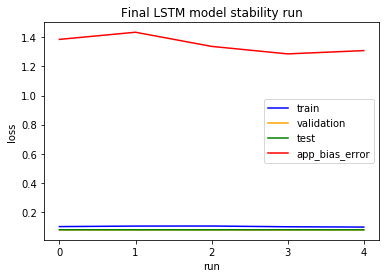

In [6]:
# plot train and validation loss across multiple runs
plt.plot(train.T, color='blue', label='train')
plt.plot(val.T, color='orange', label='validation')
plt.plot(holdout.T, color='green', label='test')
plt.plot(app_bias_error.T, color='red', label='app_bias_error')
plt.legend()

plt.title('Final LSTM model stability run')
plt.ylabel('loss')
plt.xlabel('run')
plt.show()

In [3]:
final_stable_model_list = [train, val, holdout, app_bias_error]


with open('final_LSTM_model_stability', 'wb') as f:
                        pickle.dump(final_stable_model_list, f)

In [4]:
final_stable_model_list

[          0         1         2         3         4
 0  0.098366  0.101911  0.102354  0.097172  0.095107,
           0         1         2         3         4
 0  0.075788  0.075704  0.075573  0.075548  0.075567,
           0         1         2         3         4
 0  0.076595  0.076435  0.076399  0.076414  0.076365,
           0         1         2         3         4
 0  1.386018  1.435165  1.337829  1.286261  1.308884]